In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
import holidays
import optuna
from optuna.samplers import TPESampler
from darts.metrics import mae, rmse
from darts.models import TFTModel
from darts.utils.callbacks import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.callbacks import Callback, LearningRateMonitor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from darts.models import TFTModel
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import gc
import datetime
import sys
warnings.filterwarnings('ignore')

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `XGBoost` module could not be imported. To enable XGBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [2]:
df = pd.read_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/alldata.csv')

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

In [3]:
train_end = pd.Timestamp('2024-12-30 23:00:00')
val_end   = pd.Timestamp('2025-04-30 23:00:00')  


train = df[df['datetime'] <= train_end].copy()
val = df[(df['datetime'] > train_end) & (df['datetime'] <= val_end)].copy()
test = df[df['datetime'] > val_end].copy()

In [4]:
print(df.columns)

Index(['Unnamed: 0', 'datetime', 'price', 'total_gen_forecast',
       'total_gen_actual', 'wind_onshore_forecast', 'wind_onshore_actual',
       'wind_offshore_forecast', 'wind_offshore_actual', 'solar_forecast',
       'solar_actual', 'load_actual', 'load_forecast', 'gen_biomass',
       'gen_gas', 'gen_hydro_river', 'gen_nuclear', 'gen_other',
       'gen_solar_actual', 'gen_waste', 'year', 'forecast_error',
       'wind_onshore_error', 'wind_offshore_error', 'load_error', 'hour',
       'month', 'renewable_share', 'renewable_quartile', 'dayofweek',
       'price_diff', 'price_lag24'],
      dtype='object')


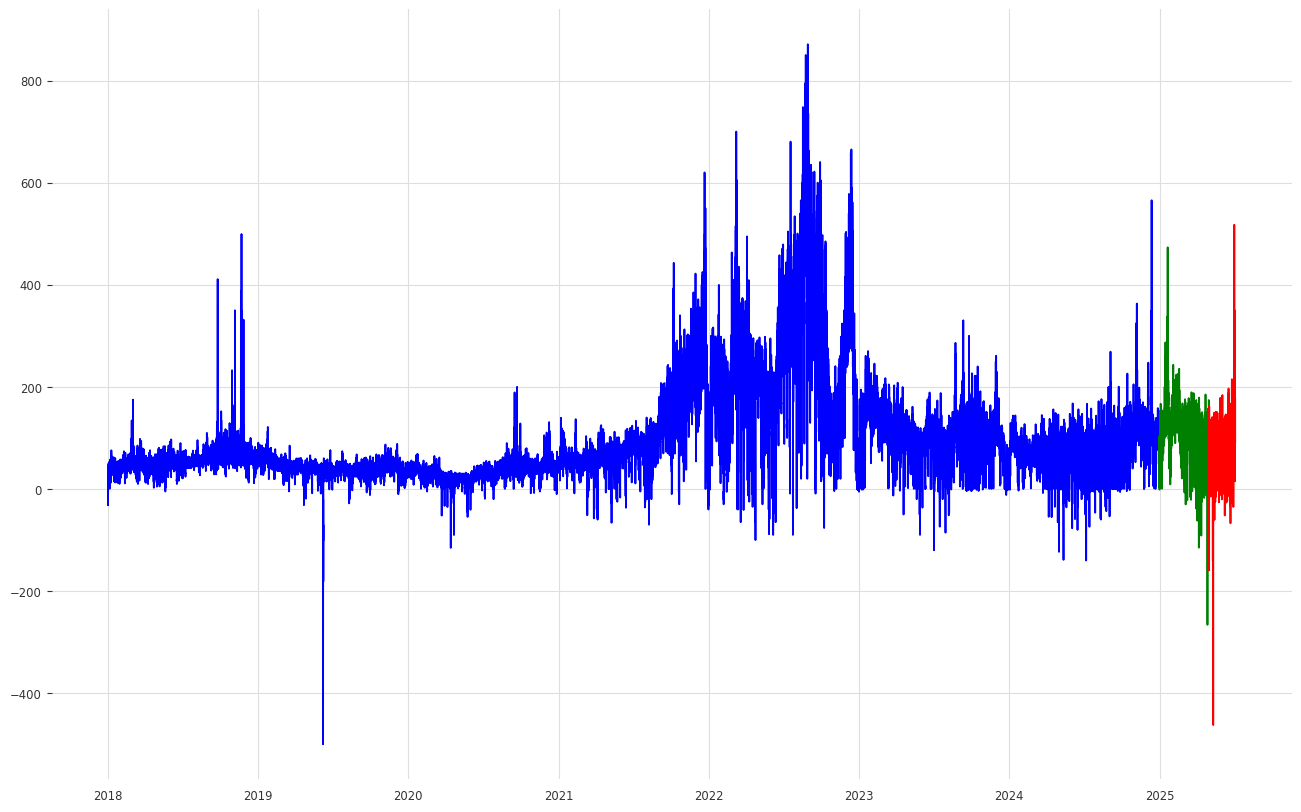

In [5]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(train['datetime'], train['price'],label="Train",
    color='blue')

ax.plot(val['datetime'], val['price'],label="Validation",
    color='green')

ax.plot(test['datetime'], test['price'],label="Test",
    color='red')

## Creation of new features for thet TFT

#### Residual load

In [6]:
df['residual_load_forecast'] = df['load_forecast'] - (
    df['solar_forecast'] + 
    df['wind_onshore_forecast'] + 
    df['wind_offshore_forecast']
)
df['residual_load_actual'] = df['load_actual'] - (
    df['solar_actual'] + 
    df['wind_onshore_actual'] + 
    df['wind_offshore_actual']
)

#### Thermal gap

In [7]:
df['gen_nuclear_proxy_forecast'] = df['gen_nuclear'].shift(24).bfill()
df['gen_hydro_proxy_forecast'] = df['gen_hydro_river'].shift(24).bfill()

df['thermal_gap_forecast'] = df['residual_load_forecast'] - (
    df['gen_nuclear_proxy_forecast'] + 
    df['gen_hydro_proxy_forecast']
)

df['thermal_gap_actual'] = df['residual_load_actual'] - (
    df['gen_nuclear'] + 
    df['gen_hydro_river']
)

#### Gas/nuclear share

In [8]:
df['gas_share'] = df['gen_gas'] / df['load_actual']
df['nuclear_share'] = df['gen_nuclear'] / df['load_actual']

#### temporal 

In [9]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [10]:
be_holidays = holidays.BE()
df['is_holiday'] = df['datetime'].apply(lambda x: x in be_holidays).astype(int)

#### Price memory

In [11]:
df['price_lag168'] = df['price'].shift(168)

df['price_rolling_mean_24h'] = df['price'].rolling(window=24).mean()

df['price_volatility_24h'] = df['price'].rolling(window=24).std()

In [12]:
df = df.bfill().ffill()

### Covariates

In [13]:
target_col = 'price'


future_cols = [
    'thermal_gap_forecast', 
    'residual_load_forecast', 
    'load_forecast', 'solar_forecast', 
    'wind_onshore_forecast', 
    'hour_sin', 'hour_cos', 
    'day_sin', 'day_cos', 
    'month_sin', 
    'month_cos',
    'is_holiday'
]


past_cols = [
    'thermal_gap_actual', 
    'residual_load_actual',
    'gas_share', 
    'nuclear_share',
    'price_lag168', 
    'price_rolling_mean_24h', 
    'price_volatility_24h',
    'price_lag24', 
    'gen_gas', 
    'gen_nuclear'
]

### Timeseries

In [14]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler


target_col = 'price'

ts_target = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=target_col, freq='H').astype(np.float32)
ts_future = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=future_cols, freq='H').astype(np.float32)
ts_past = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=past_cols, freq='H').astype(np.float32)

### Scaling

In [15]:
val_start_date = pd.Timestamp('2024-01-01') 
test_start_date = pd.Timestamp('2025-01-01')


ts_target_log = ts_target.map(np.arcsinh)
ts_past_log = ts_past.map(np.arcsinh)
ts_future_log = ts_future.map(np.arcsinh)

train_target_subset, _ = ts_target_log.split_before(val_start_date)
train_past_subset, _ = ts_past_log.split_before(val_start_date)
train_future_subset, _ = ts_future_log.split_before(val_start_date)

scaler_target = Scaler(StandardScaler())
scaler_past = Scaler(StandardScaler())
scaler_future = Scaler(StandardScaler())

scaler_target.fit(train_target_subset)
scaler_past.fit(train_past_subset)
scaler_future.fit(train_future_subset)
ts_target_scaled = scaler_target.transform(ts_target_log)
ts_past_scaled = scaler_past.transform(ts_past_log)
ts_future_scaled = scaler_future.transform(ts_future_log)



train_final = ts_target_scaled.slice(ts_target_scaled.start_time(), val_start_date - pd.Timedelta(hours=1))


val_final = ts_target_scaled.slice(val_start_date, test_start_date - pd.Timedelta(hours=1))


test_final = ts_target_scaled.slice(test_start_date, ts_target_scaled.end_time())

print(f"Train size: {len(train_final)} hours")
print(f"Val size: {len(val_final)} hours")
print(f"Test size: {len(test_final)} hours")

Train size: 52584 hours
Val size: 8784 hours
Test size: 4417 hours


In [16]:
!pip install optuna 

In [16]:
import optuna
from optuna.samplers import TPESampler
from darts.metrics import mae, rmse

In [ ]:
def log_msg(message):
    print(f"[{datetime.datetime.now().strftime('%H:%M:%S')}] {message}")

def objective_fast(trial):

    params = {
        'input_chunk_length': trial.suggest_categorical('input_chunk_length', [96, 168]),
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128]),
        'lstm_layers': trial.suggest_int('lstm_layers', 2, 3),
        'num_attention_heads': trial.suggest_categorical('num_attention_heads', [4, 8]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.25, step=0.05),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64]),
        'lr': trial.suggest_float('lr', 0.0001, 0.002, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True),
    }
    
    log_msg(f"start trial {trial.number}")
    print(f"Params : {params}")
    
    try:
        early_stopper = EarlyStopping(
            monitor="val_loss",
            patience=5,
            min_delta=0.001,
            mode='min',
        )

        model = TFTModel(
            input_chunk_length=params['input_chunk_length'],
            output_chunk_length=24,
            hidden_size=params['hidden_size'],
            lstm_layers=params['lstm_layers'],
            num_attention_heads=params['num_attention_heads'],
            dropout=params['dropout'],
            hidden_continuous_size=16,  
            batch_size=params['batch_size'],
            n_epochs=30,  
            add_relative_index=True,
            optimizer_kwargs={
                "lr": params['lr'],
                "weight_decay": params['weight_decay']
            },
            random_state=42,
            force_reset=True,
            save_checkpoints=False,
            pl_trainer_kwargs={
                "accelerator": "mps", 
                "enable_progress_bar": True, 
                "callbacks": [early_stopper],
                "gradient_clip_val": 0.1
            }
        )


        model.fit(
            series=train_final,
            past_covariates=ts_past_scaled,   
            future_covariates=ts_future_scaled,
            val_series=val_final, 
            val_past_covariates=ts_past_scaled,
            val_future_covariates=ts_future_scaled,
            
            verbose=True 
        )
        



        n_samples = 5  
        mae_scores = []
        
        for i in range(n_samples):
            sys.stdout.write(f"\r   > Sample prediction {i+1}/{n_samples}...")
            sys.stdout.flush()

            start_idx = params['input_chunk_length'] + i * 24
            if start_idx + 24 > len(val_final):
                break

            pred = model.predict(
                n=24,
                series=val_final[:start_idx],
                past_covariates=ts_past_scaled,
                future_covariates=ts_future_scaled,
                num_samples=1,
                verbose=False 
            )

            pred_original = scaler_target.inverse_transform(pred)
            pred_original = pred_original.map(np.sinh)
            
            val_slice = val_final[start_idx:start_idx+24]
            val_original = scaler_target.inverse_transform(val_slice)
            val_original = val_original.map(np.sinh)
            
            mae_scores.append(float(mae(val_original, pred_original)))

        print("") 
        mae_score = np.mean(mae_scores)
        
        log_msg(f"TRIAL {trial.number} DONE | MAE: {mae_score:.2f} EUR/MWh")
        

        del model
        gc.collect()
        
        return mae_score
        
    except Exception as e:
        log_msg(f"Trial {trial.number} FAILED: {str(e)}")
        return float('inf')


print("Optuna searching")

study_fast = optuna.create_study(
    study_name="tft_fast_optimization",
    direction='minimize',
    sampler=TPESampler(seed=42),
)

study_fast.optimize(
    objective_fast,
    n_trials=20, 
    gc_after_trial=True
)

if len(study_fast.trials) > 0:
    print(f"\n{'='*30}")
    print(f"best result found")
    best_trial = study_fast.best_trial
    print(f"Score MAE: {best_trial.value:.2f} EUR/MWh")
    print(f"Hyperparams:")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")

    import json
    with open('best_params_fast.json', 'w') as f:
        json.dump(best_trial.params, f, indent=2)

[I 2025-11-23 15:43:50,497] A new study created in memory with name: tft_fast_optimization
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 86.4 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 44.1 K | train
6  | static_context_grn                | _GatedResidualNetw

Optuna searching
[15:43:50] start trial 0
Params : {'input_chunk_length': 168, 'hidden_size': 64, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.25, 'batch_size': 64, 'lr': 0.00010636066512540289, 'weight_decay': 0.0008706020878304854}
[15:43:50] Training ...


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[I 2025-11-23 15:47:24,430] Trial 0 finished with value: inf and parameters: {'input_chunk_length': 168, 'hidden_size': 64, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.25, 'batch_size': 64, 'lr': 0.00010636066512540289, 'weight_decay': 0.0008706020878304854}. Best is trial 0 with value: inf.


[15:47:24] Trial 0 FAILED: name 'exit' is not defined


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 147 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 77.4 K | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

[15:47:24] start trial 1
Params : {'input_chunk_length': 96, 'hidden_size': 128, 'lstm_layers': 2, 'num_attention_heads': 4, 'dropout': 0.15000000000000002, 'batch_size': 32, 'lr': 0.00023993242906812716, 'weight_decay': 5.4041038546473305e-05}
[15:47:24] Training ...


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

In [19]:
import json

with open('best_params_fast.json', 'r') as f:
    best_params = json.load(f)

print("Best params :", best_params)


lr = best_params.pop('lr')
weight_decay = best_params.pop('weight_decay')

early_stopper_final = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.001,
    mode='min',
)


final_model = TFTModel(
    **best_params,
    output_chunk_length=24, 
    hidden_continuous_size=16,
    add_relative_index=True,
    n_epochs=50,
    random_state=42,
    force_reset=True,
    save_checkpoints=True,
    optimizer_kwargs={
        "lr": lr,
        "weight_decay": weight_decay
    },
    pl_trainer_kwargs={
        "accelerator": "mps", 
        "enable_progress_bar": True,
        "gradient_clip_val": 0.1,
        "callbacks": [early_stopper_final]
    }
)

final_model.fit(
    series=train_final,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    val_series=val_final,
    val_past_covariates=ts_past_scaled,
    val_future_covariates=ts_future_scaled,
    verbose=True
)


Best params : {'input_chunk_length': 168, 'hidden_size': 128, 'lstm_layers': 3, 'num_attention_heads': 8, 'dropout': 0.1, 'batch_size': 32, 'lr': 0.0006472246762907428, 'weight_decay': 1.051355058786047e-05}
Démarrage de l'entraînement final...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 147 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 77.4 K | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=3, num_attention_heads=8, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=16, categorical_embedding_sizes=None, add_relative_index=True, skip_interpolation=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, batch_size=32, output_chunk_length=24, n_epochs=50, random_state=42, force_reset=True, save_checkpoints=True, optimizer_kwargs={'lr': 0.0006472246762907428, 'weight_decay': 1.051355058786047e-05}, pl_trainer_kwargs={'accelerator': 'mps', 'enable_progress_bar': True, 'gradient_clip_val': 0.1, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x307b94d90>]})

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Génération des prédictions sur le jeu de Test (2025)...


Predicting: |                                             | 0/? [00:00<?, ?it/s]

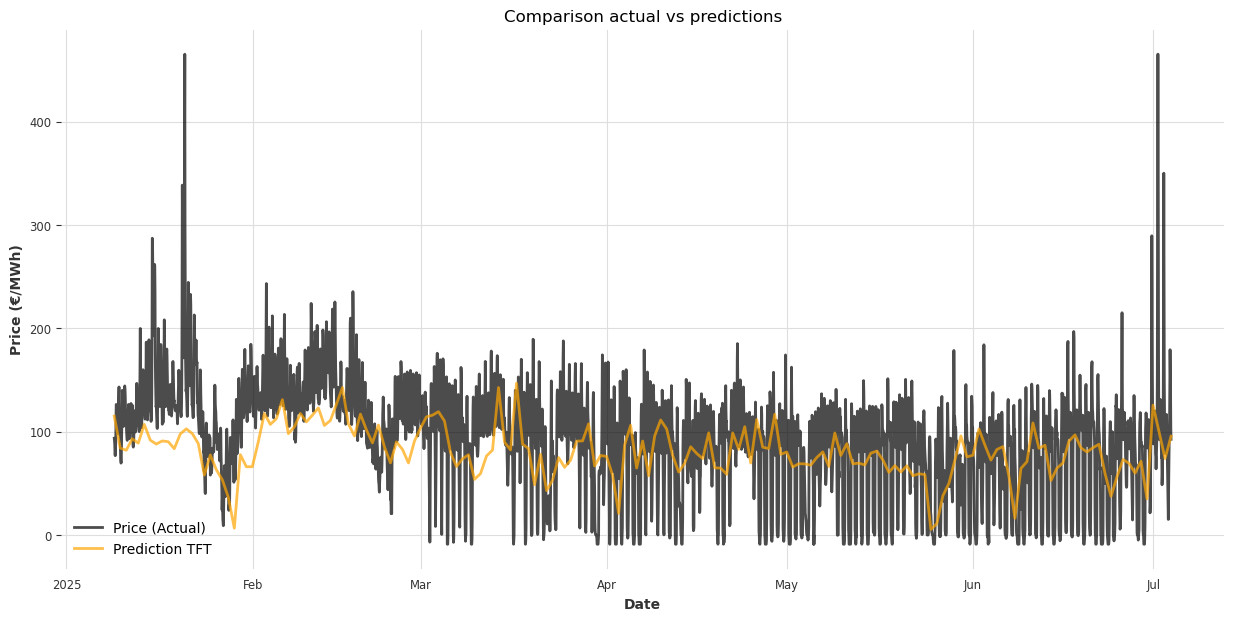

In [71]:
import matplotlib.pyplot as plt
from darts.metrics import mae, rmse

print("Génération des prédictions sur le jeu de Test (2025)...")


backtest_series = final_model.historical_forecasts(
    series=test_final,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    start=best_params['input_chunk_length'], 
    forecast_horizon=24,
    stride=24,
    retrain=False,
    verbose=True
)


backtest_original = scaler_target.inverse_transform(backtest_series)

backtest_original = backtest_original.map(np.sinh)


test_original_scaled = scaler_target.inverse_transform(test_final)
test_original = test_original_scaled.map(np.sinh)

actuals = test_original.slice(backtest_original.start_time(), backtest_original.end_time())


test_mae = mae(actuals, backtest_original)
test_rmse = rmse(actuals, backtest_original)


plt.figure(figsize=(15, 7))
actuals.plot(label='Price (Actual)', alpha=0.7)
backtest_original.plot(label='Prediction TFT', alpha=0.7, color='orange')
plt.title('Comparison actual vs predictions')
plt.legend()
plt.ylabel('Price (€/MWh)')
plt.xlabel('Date')
plt.show()

### Suppression of the extreme quantiles

In [17]:
q01 = df['price'].quantile(0.01) 
q99 = df['price'].quantile(0.99) 

nb_low = len(df[df['price'] < q01])
nb_high = len(df[df['price'] > q99])

In [18]:
df['price'] = df['price'].clip(lower=q01, upper=q99)



target_col = 'price'

ts_target = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=target_col, freq='H').astype(np.float32)
ts_future = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=future_cols, freq='H').astype(np.float32)
ts_past = TimeSeries.from_dataframe(df, time_col='datetime', value_cols=past_cols, freq='H').astype(np.float32)

val_start_date = pd.Timestamp('2024-01-01')
test_start_date = pd.Timestamp('2025-01-01')

ts_target_log = ts_target.map(np.arcsinh)
ts_past_log = ts_past.map(np.arcsinh)
ts_future_log = ts_future.map(np.arcsinh)

train_target_subset, _ = ts_target_log.split_before(val_start_date)
train_past_subset, _ = ts_past_log.split_before(val_start_date)
train_future_subset, _ = ts_future_log.split_before(val_start_date)

scaler_target = Scaler(StandardScaler())
scaler_past = Scaler(StandardScaler())
scaler_future = Scaler(StandardScaler())

scaler_target.fit(train_target_subset)
scaler_past.fit(train_past_subset)
scaler_future.fit(train_future_subset)

ts_target_scaled = scaler_target.transform(ts_target_log)
ts_past_scaled = scaler_past.transform(ts_past_log)
ts_future_scaled = scaler_future.transform(ts_future_log)

train_final = ts_target_scaled.slice(ts_target_scaled.start_time(), val_start_date - pd.Timedelta(hours=1))
val_final = ts_target_scaled.slice(val_start_date, test_start_date - pd.Timedelta(hours=1))
test_final = ts_target_scaled.slice(test_start_date, ts_target_scaled.end_time())

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 659 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 347 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 66.3 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetw

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

Generating TimeSeries:   0%|          | 0/177 [00:00<?, ?it/s]

MAE : 27.05 EUR/MWh


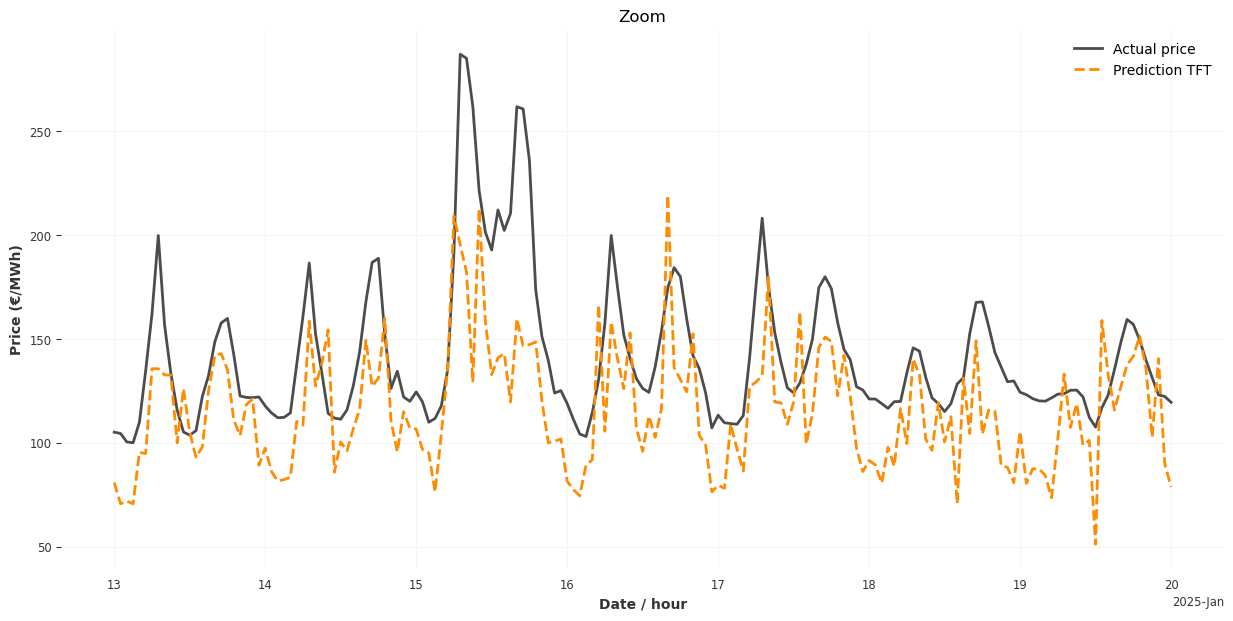

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.metrics import mae
from darts.models import TFTModel
from pytorch_lightning.callbacks import EarlyStopping
from torch.optim.lr_scheduler import ReduceLROnPlateau

params_quick_check = {
    'input_chunk_length': 168,
    'output_chunk_length': 24,
    'hidden_size': 128,         
    'lstm_layers': 3,           
    'num_attention_heads': 8,
    'dropout': 0.35,            
    'batch_size': 64,           
    'n_epochs': 5,             
}

initial_lr = 0.0001
best_weight_decay = 5e-4


final_model = TFTModel(
    **params_quick_check,
    hidden_continuous_size=64,
    add_relative_index=True,
    random_state=42,
    force_reset=True,
    save_checkpoints=False, 
    optimizer_kwargs={
        "lr": initial_lr,
        "weight_decay": best_weight_decay
    },
    lr_scheduler_cls=ReduceLROnPlateau,
    lr_scheduler_kwargs={
        "monitor": "val_loss",
        "patience": 4,
        "factor": 0.5,
    },
    pl_trainer_kwargs={
        "accelerator": "mps",
        "enable_progress_bar": True,
        "gradient_clip_val": 1.0,
        "callbacks": [EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001, mode='min')],
    }
)

final_model.fit(
    series=train_final,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    val_series=val_final,
    val_past_covariates=ts_past_scaled,
    val_future_covariates=ts_future_scaled,
    verbose=True
)


input_chunk_length = 168 

forecast_blocks = final_model.historical_forecasts(
    series=test_final,
    past_covariates=ts_past_scaled,
    future_covariates=ts_future_scaled,
    start=input_chunk_length, 
    forecast_horizon=24, 
    stride=24, 
    retrain=False,
    last_points_only=False, 
    verbose=True
)


if isinstance(forecast_blocks, list):
    pred_series = forecast_blocks[0]
    for ts in forecast_blocks[1:]:
        pred_series = pred_series.concatenate(ts, axis=0)
else:
    pred_series = forecast_blocks 

pred_original = scaler_target.inverse_transform(pred_series).map(np.sinh)
test_original = scaler_target.inverse_transform(test_final).map(np.sinh)
actuals = test_original.slice(pred_original.start_time(), pred_original.end_time())

current_mae = mae(actuals, pred_original)

print(f"MAE : {current_mae:.2f} EUR/MWh")


zoom_start = pd.Timestamp('2025-01-13')
zoom_end = pd.Timestamp('2025-01-20')

plt.figure(figsize=(15, 7))

actuals.slice(zoom_start, zoom_end).plot(label='Actual price', linewidth=2, color='black', alpha=0.7)

pred_original.slice(zoom_start, zoom_end).plot(
    label='Prediction TFT', 
    color='#FF8C00', 
    linewidth=2,
    linestyle='--'
)

plt.title(f'Zoom')
plt.xlabel('Date / hour')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

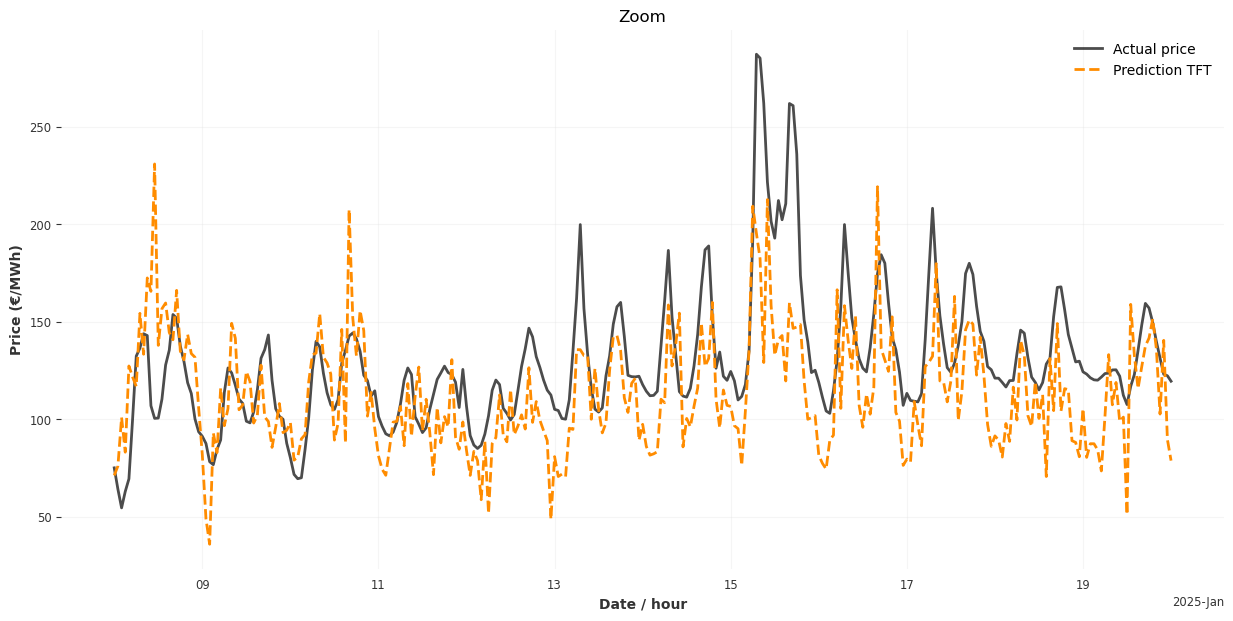

In [25]:
zoom_start = pd.Timestamp('2025-01-01')
zoom_end = pd.Timestamp('2025-01-20')

plt.figure(figsize=(15, 7))

actuals.slice(zoom_start, zoom_end).plot(label='Actual price', linewidth=2, color='black', alpha=0.7)

pred_original.slice(zoom_start, zoom_end).plot(
    label='Prediction TFT', 
    color='#FF8C00', 
    linewidth=2,
    linestyle='--'
)

plt.title(f'Zoom')
plt.xlabel('Date / hour')
plt.ylabel('Price (€/MWh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()